In [20]:
import os
from skimage import io
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import shutil
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns

In [2]:
batch_size = 32
img_height = 300
img_width = 200

In [38]:
num_classes = 3
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [5]:
def get_model_name():
    import time
    run=time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return run

In [6]:
recall=tf.keras.metrics.Recall(class_id=None)

In [7]:
root_logdir=os.path.join(os.curdir, 'my_logs')

In [8]:
def get_run_logdir():
    import time
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [27]:
run_logdir=get_run_logdir()
model_name=get_model_name()

In [44]:
def scheduler(epoch, lr):
  if epoch < 200:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

In [45]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-5 less"
        min_delta=1e-7,
        # "no longer improving" being further defined as "for at least 30 epochs"
        patience=45,
        verbose=1,), 
    keras.callbacks.TensorBoard(run_logdir,
                              histogram_freq=2,
                              write_graph=True,
                              write_images=True),
    keras.callbacks.ModelCheckpoint(filepath='models/'+model_name ,save_best_only=True), 
    keras.callbacks.LearningRateScheduler(scheduler)]

In [46]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=30, width_shift_range=0.3,
    height_shift_range=0.3, fill_mode='nearest', cval=0.0,
    horizontal_flip=True, vertical_flip=False, zoom_range=0.25, brightness_range=(0.75, 1.25))
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator()

In [47]:
train_generator = train_datagen.flow_from_directory(
        'plants/train',
        target_size=(300, 200),
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        'plants/val',
        target_size=(300, 200),
        batch_size=32,
        class_mode='categorical')

Found 1968 images belonging to 3 classes.
Found 422 images belonging to 3 classes.


In [24]:
optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [40]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[recall])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 200, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 25, 128)       0

In [30]:
weight_for_0 = (1 / 1800)*(2200)/2.0 
weight_for_1 = (1 / 400)*(2200)/2.0
weight_for_2 = (1/400)*(2200)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [31]:
epochs=600
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs,
    callbacks=[callbacks], class_weight=class_weight)

Epoch 1/600
62/62 [==============================] - ETA: 0s - loss: 1.3573 - recall: 0.0478WARNING:tensorflow:From /Users/johnwilliams/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/run_2021_01_12-07_24_38/assets
62/62 [==============================] - 171s 3s/step - loss: 1.3573 - recall: 0.0478 - val_loss: 1.1012 - val_recall: 0.0000e+00
Epoch 2/600
62/62 [==============================] - 167s 3s/step - loss: 1.3345 - recall: 0.0025 - val_loss: 1.1413 - val_recall: 0.0355
Epoch 3/600
62/62 [==============================] - 169s 3s/step - loss

62/62 [==============================] - 168s 3s/step - loss: 1.0932 - recall: 0.4609 - val_loss: 0.8055 - val_recall: 0.5000
Epoch 43/600
62/62 [==============================] - 167s 3s/step - loss: 1.0974 - recall: 0.4390 - val_loss: 0.9199 - val_recall: 0.3886
Epoch 44/600
62/62 [==============================] - 175s 3s/step - loss: 1.0968 - recall: 0.4273 - val_loss: 0.8128 - val_recall: 0.4787
Epoch 45/600
62/62 [==============================] - 172s 3s/step - loss: 1.0835 - recall: 0.4842 - val_loss: 0.8927 - val_recall: 0.4147
Epoch 46/600
62/62 [==============================] - 173s 3s/step - loss: 1.0905 - recall: 0.4416 - val_loss: 0.8389 - val_recall: 0.4645
Epoch 47/600
62/62 [==============================] - 173s 3s/step - loss: 1.0995 - recall: 0.4360 - val_loss: 0.8438 - val_recall: 0.4550
Epoch 48/600
62/62 [==============================] - 173s 3s/step - loss: 1.0962 - recall: 0.4345 - val_loss: 0.8254 - val_recall: 0.4716
Epoch 49/600
62/62 [====================

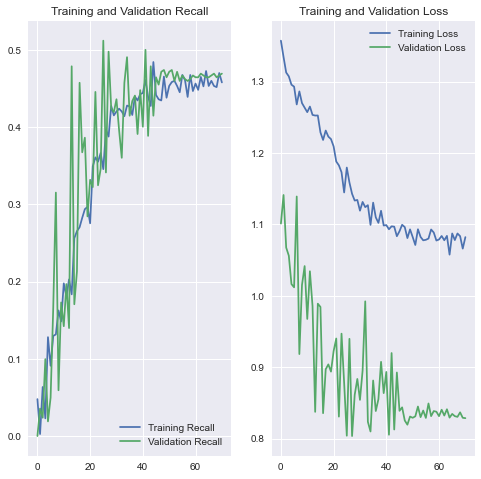

In [34]:
plt.style.use('seaborn')
acc = history.history['recall']
val_acc = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Recall')
plt.plot(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('graphs/simplemodel128x2weight_slow1.png', bbox_inches='tight')
plt.show()

In [48]:
epochs=600
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs,
    callbacks=[callbacks], class_weight=class_weight)

Epoch 1/600
62/62 [==============================] - 179s 3s/step - loss: 1.3498 - recall: 0.0000e+00 - val_loss: 1.0414 - val_recall: 0.0000e+00
Epoch 2/600
62/62 [==============================] - 176s 3s/step - loss: 1.3496 - recall: 0.0000e+00 - val_loss: 1.0464 - val_recall: 0.0000e+00
Epoch 3/600
62/62 [==============================] - 182s 3s/step - loss: 1.3476 - recall: 0.0000e+00 - val_loss: 1.0455 - val_recall: 0.0000e+00
Epoch 4/600
62/62 [==============================] - 178s 3s/step - loss: 1.3480 - recall: 0.0000e+00 - val_loss: 1.0413 - val_recall: 0.0000e+00
Epoch 5/600
62/62 [==============================] - 179s 3s/step - loss: 1.3480 - recall: 0.0000e+00 - val_loss: 1.0450 - val_recall: 0.0000e+00
Epoch 6/600
62/62 [==============================] - 177s 3s/step - loss: 1.3466 - recall: 0.0000e+00 - val_loss: 1.0439 - val_recall: 0.0000e+00
Epoch 7/600
62/62 [==============================] - 177s 3s/step - loss: 1.3481 - recall: 0.0000e+00 - val_loss: 1.0442 - v

KeyboardInterrupt: 

In [64]:
poison_ivy_benign=[46,17,51,25]
poison_oak_benign=[27,15,12,12]
benign_benign=[87,69,91,79]
labels=[" ",'no augment'," ", 'augment'," ", 'too much augment'," ", 'augment with weighted classes']
x=[1,2,3,4]

In [69]:
fig, ax=plt.subplots()
ax.plot(x, poison_ivy_benign, label="% Poison Ivy id'd as Benign")
ax.plot(x, poison_oak_benign,label="% Poison Oak id'd as Benign")
ax.plot(x, benign_benign, label="% Benign id'd as Benign")
ax.set_ylabel('Percent Labeled')
ax.set_xticklabels(labels)
ax.set_xlim(0.9,4.1)
ax.legend(loc=(0.75, 0.75)
ax.set_title("Impact of Augment and Weight");

SyntaxError: invalid syntax (<ipython-input-69-be4ea996ed04>, line 9)